# Salary Prediction from LinkedIn Job Postings - Train Linear Model

In [1]:
import pandas as pd, numpy as np
import salary
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold, GridSearchCV

/var/folders/vm/77wrgjgj5wzbyghx353b7gym0000gn/T/ipykernel_91447/3242428450.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd, numpy as np
/Users/nginyc/repos/job_posting_salary_prediction/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Train & Evaluate Model

In [2]:
(X_train, y_train) = salary.get_train_dataset()
(X_test, y_test) = salary.get_test_dataset()

In [3]:
preprocessor = make_pipeline(
    ColumnTransformer(
        transformers=[
            ('one_hot_encoder', OneHotEncoder(use_cat_names=True), ['norm_title', 'clustered_edu_req', 'clustered_pref_qual', 'clustered_req_skill', 'location_state', 'company_industries', 'formatted_experience_level', 'formatted_work_type']),
            ('target_encoder', TargetEncoder(), ['norm_title', 'clustered_edu_req', 'clustered_pref_qual', 'clustered_req_skill', 'location_state', 'company_industries', 'formatted_experience_level', 'formatted_work_type']),
            ('experience_level', salary.experience_level_encoder, ['formatted_experience_level']),
            ('work_type', salary.work_type_encoder, ['formatted_work_type']),
            ('remote_allowed', 'passthrough', ['remote_allowed']),
            ('company_employee_count', SimpleImputer(strategy='median'), ['company_employee_count']),
        ],
        remainder='drop'
    ),
    StandardScaler(),
)

### Ridge (L2 Regularization)

In [4]:
model_ridge = make_pipeline(
    clone(preprocessor),
    GridSearchCV(
        Ridge(),
        { 'alpha': [0, 0.01, 0.1, 1, 10, 100] },
        scoring='r2',
        cv=KFold(n_splits=5, shuffle=True, random_state=42)
    )
).fit(X_train, y_train)

In [5]:
result_train_ridge = salary.evaluate_train_predictions(model_ridge.predict(X_train))
result_test_ridge = salary.evaluate_test_predictions(model_ridge.predict(X_test))

Train R2: 0.4164
Train RMSE: 46993.9589
Train MAE: 29568.2613
Test R2: 0.4427
Test RMSE: 43520.1211
Test MAE: 28946.8526


In [6]:
model_ridge[-1].best_params_

{'alpha': 100}

### Lasso (L1 Regularization)

In [7]:
model_lasso = make_pipeline(
    clone(preprocessor),
    GridSearchCV(
        Lasso(),
        { 'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10] },
        scoring='r2',
        cv=KFold(n_splits=5, shuffle=True, random_state=42)
    )
).fit(X_train, y_train)

/Users/nginyc/repos/job_posting_salary_prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.311e+12, tolerance: 8.589e+09
  model = cd_fast.enet_coordinate_descent(
/Users/nginyc/repos/job_posting_salary_prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.916e+12, tolerance: 8.174e+09
  model = cd_fast.enet_coordinate_descent(
/Users/nginyc/repos/job_posting_salary_prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the nu

In [8]:
result_train_lasso = salary.evaluate_train_predictions(model_lasso.predict(X_train))
result_test_lasso = salary.evaluate_test_predictions(model_lasso.predict(X_test))

Train R2: 0.4164
Train RMSE: 46994.2477
Train MAE: 29564.1939
Test R2: 0.4428
Test RMSE: 43517.2217
Test MAE: 28939.6981


In [9]:
model_lasso[-1].best_params_

{'alpha': 10}

### Compare Models

/Users/nginyc/repos/job_posting_salary_prediction/salary.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Test R²', data=metrics_df, ax=axes[0], palette='Blues')
/Users/nginyc/repos/job_posting_salary_prediction/salary.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=x_label_rotation)
/Users/nginyc/repos/job_posting_salary_prediction/salary.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Test RMSE', data=metrics_df, ax=axes[1], palette='Greens')
/Users/nginyc/repos/job_posting_salary_prediction/salary.py:

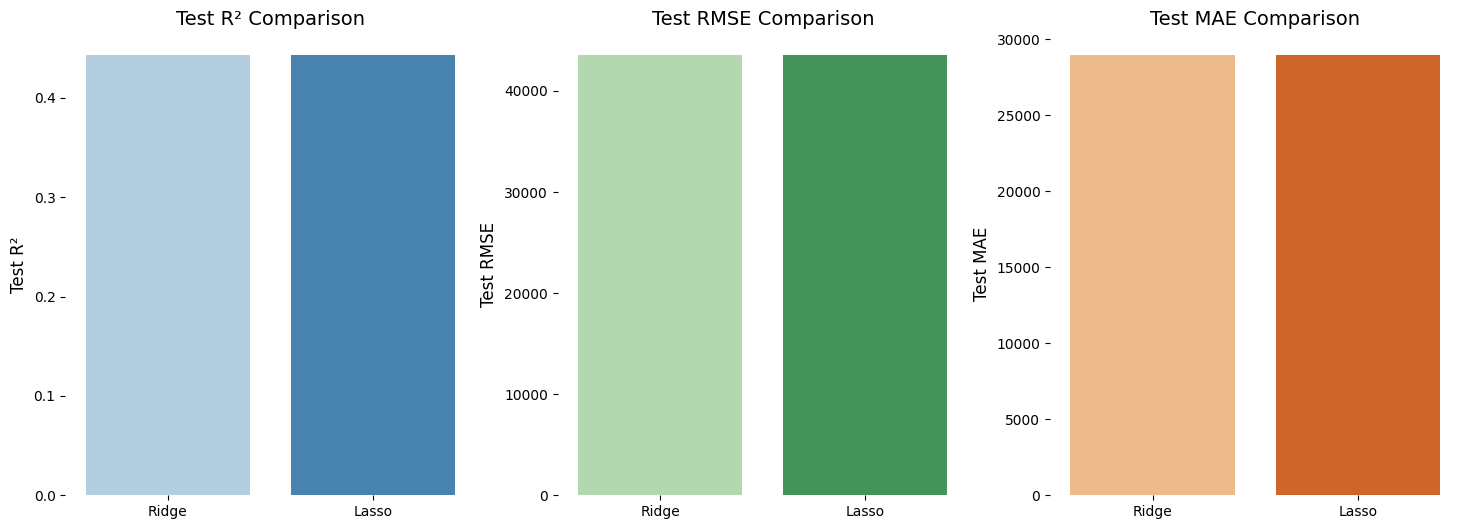

In [16]:
salary.plot_evaluation_results(['Ridge', 'Lasso'], [result_test_ridge, result_test_lasso])

## Train & Evaluate Best Model

In [21]:
best_model = make_pipeline(
    clone(preprocessor),
    Lasso(**model_lasso[-1].best_params_),
).fit(X_train, y_train)

/Users/nginyc/repos/job_posting_salary_prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.418e+11, tolerance: 1.055e+10
  model = cd_fast.enet_coordinate_descent(


,Feature,Coefficient
0,target_encoder__company_industries,9512.847841
1,one_hot_encoder__formatted_experience_level_Director,9446.935448
2,target_encoder__norm_title,9440.362042
3,one_hot_encoder__formatted_experience_level_Executive,8400.456648
4,target_encoder__clustered_edu_req,6409.028673
5,target_encoder__location_state,6208.690505
6,one_hot_encoder__formatted_experience_level_Entry level,-5325.909972
7,target_encoder__clustered_req_skill,5236.601373
8,one_hot_encoder__formatted_experience_level_Associate,-4006.45505
9,target_encoder__formatted_experience_level,3785.195041


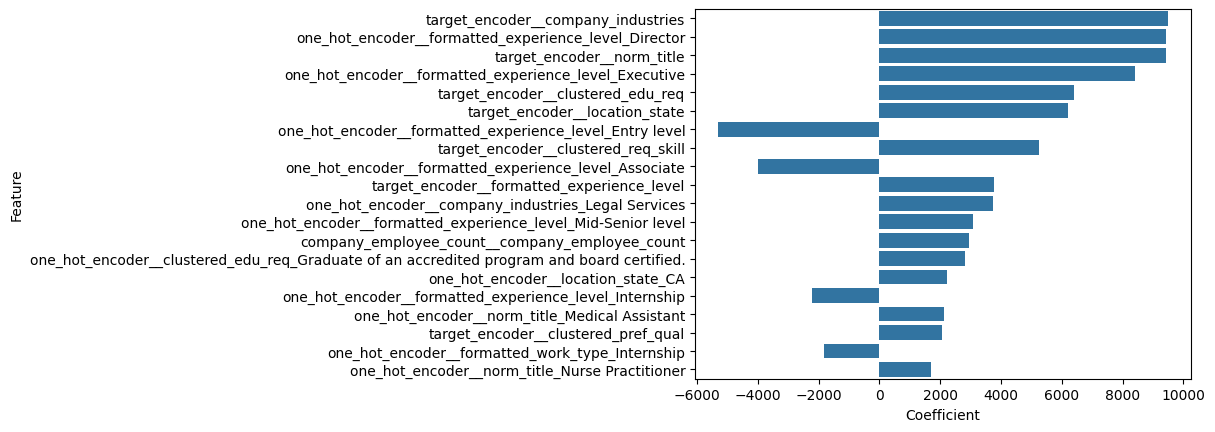

In [22]:
def get_important_features(model, n=20):
    feature_names = np.array([name[:100] for name in model[:-1].get_feature_names_out(X_train.columns)])
    coef = model[-1].coef_
    idxs = np.flip(np.argsort(np.abs(coef))[-n:])
    pd.set_option('display.max_colwidth', None)
    importance_df = pd.DataFrame([feature_names[idxs], coef[idxs]], index=["Feature", "Coefficient"]).transpose()
    sns.barplot(x="Coefficient", y="Feature", data=importance_df.head(n))
    pd.set_option('display.max_colwidth', None)
    return importance_df

get_important_features(best_model)